Drugie podejście do modelu

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os.path import join as JoinPath
from cmdstanpy import CmdStanModel
from scipy.stats import gaussian_kde

In [26]:
# Pozyskiwanie zależności
eh = pd.read_csv('electricity_household' + '.tsv', sep='\t',header=0, index_col='country')
eh_mean_list = list(eh.mean())

ei = pd.read_csv('electricity_industry' + '.tsv', sep='\t',header=0, index_col='country')
ei_mean_list = list(ei.mean())

gh = pd.read_csv('gas_household' + '.tsv', sep='\t',header=0, index_col='country')
gh = gh.drop(['1990-S2 '], axis=1) # Usunięcie wymagane poniewać eurostat wykonał tutaj jeden dodatkowy punkt pomiarowy
gh_mean_list = list(gh.mean())

gi = pd.read_csv('gas_industry' + '.tsv', sep='\t',header=0, index_col='country')
gi_mean_list = list(gi.mean())

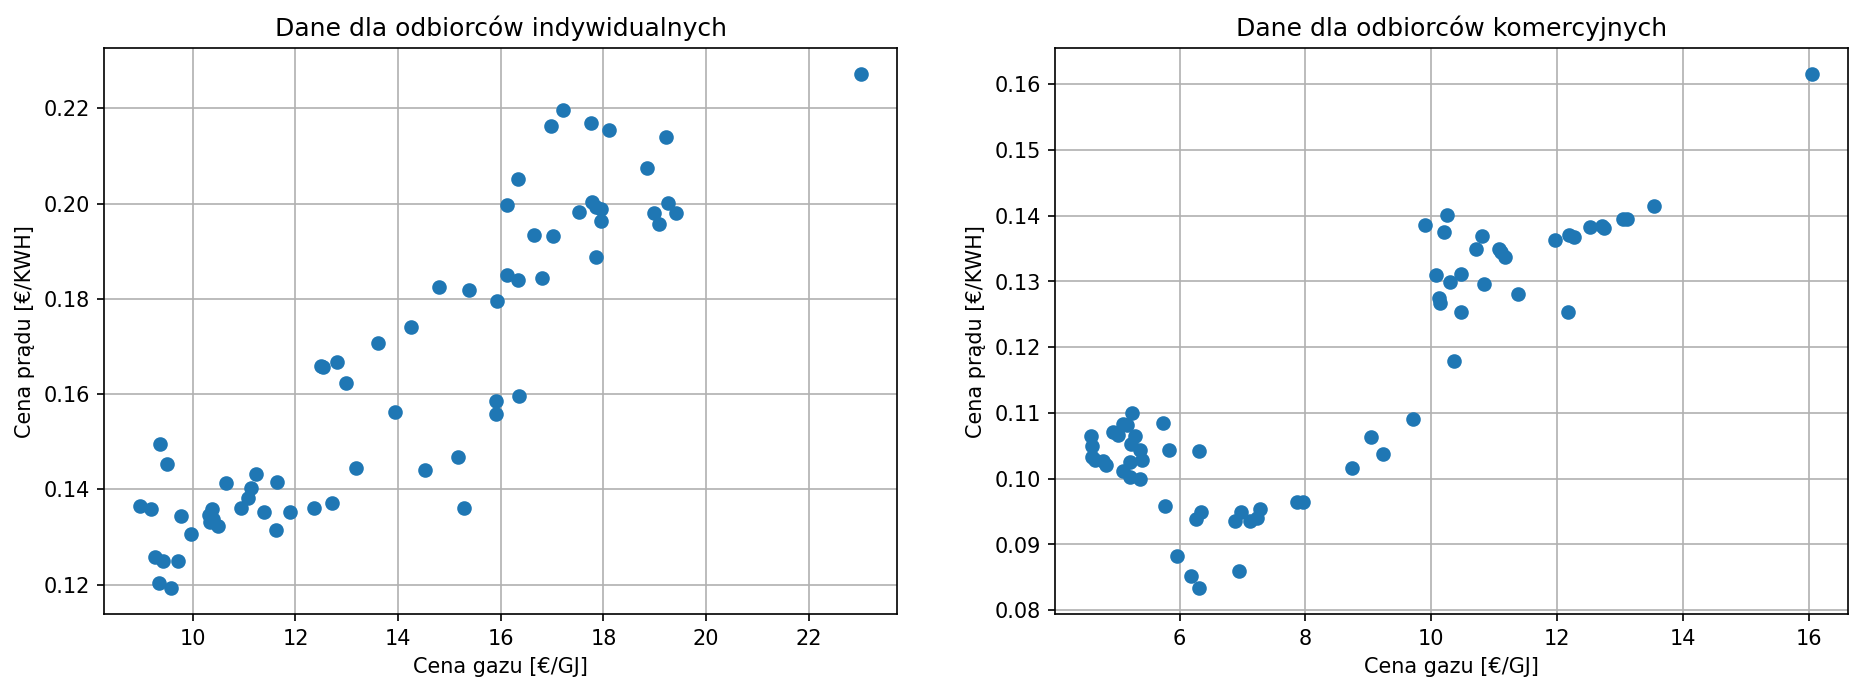

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), dpi=150)
plt.rcParams['axes.grid'] = True

ax1.plot(gh_mean_list, eh_mean_list, 'o')
ax1.set_title("Dane dla odbiorców indywidualnych")
ax1.set_xlabel("Cena gazu [€/GJ]")
ax1.set_ylabel("Cena prądu [€/KWH]")

ax2.plot(gi_mean_list, ei_mean_list, 'o')
ax2.set_title("Dane dla odbiorców komercyjnych")
ax2.set_xlabel("Cena gazu [€/GJ]")
ax2.set_ylabel("Cena prądu [€/KWH]")

plt.show()

# Obliczenia przy użyciu STAN

In [28]:
# Numer modelu oznacza stopień wielomianu dopasowania
model_1_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_1.stan'))
model_2_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_2.stan'))
model_3_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_3.stan'))
model_4_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_4.stan'))

INFO:cmdstanpy:compiling stan file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_1.stan to exe file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_1.exe
INFO:cmdstanpy:compiled model executable: E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_1.exe
INFO:cmdstanpy:compiling stan file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_2.stan to exe file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_2.exe
INFO:cmdstanpy:compiled model executable: E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_2.exe
INFO:cmdstanpy:compiling stan file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_3.stan to exe file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_3.exe
INFO:cmdstanpy:compiled model executable: E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-f

In [29]:
def fit(model, x, y):
    data = {}
    data['N'] = len(x)
    data['x'] = x
    data['y'] = y
    return model.sample(data=data, seed=2137)

In [30]:
h_fit_degree1 = fit(model_1_fit, gh_mean_list, eh_mean_list)
h_fit_degree2 = fit(model_2_fit, gh_mean_list, eh_mean_list)
h_fit_degree3 = fit(model_3_fit, gh_mean_list, eh_mean_list)
h_fit_degree4 = fit(model_4_fit, gh_mean_list, eh_mean_list)

i_fit_degree1 = fit(model_1_fit, gi_mean_list, ei_mean_list)
i_fit_degree2 = fit(model_2_fit, gi_mean_list, ei_mean_list)
i_fit_degree3 = fit(model_3_fit, gi_mean_list, ei_mean_list)
i_fit_degree4 = fit(model_4_fit, gi_mean_list, ei_mean_list)

INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status



chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |█████▍    | 00:00 Iteration: 1000 / 2000 [ 50%]  (Warmup)





chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:01 Iteration: 1900 / 2000 [ 95%]  (Sampling)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████|


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▍    | 00:01 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)



chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)




chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |█████


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed            


INFO:cmdstanpy:CmdStan done processing.


# Wyświetlanie danych wynikowych dopasowania

In [31]:
def PlotFitedData(x, y, fit_data, fit_degree, ax):
    alpha = np.mean(fit_data.stan_variable("alpha"))
    beta = np.mean(fit_data.stan_variable("beta"))
    gamma = None
    if fit_degree > 1:
        gamma = np.mean(fit_data.stan_variable("gamma"))
    delta = None
    if fit_degree > 2:
        delta = np.mean(fit_data.stan_variable("delta"))
    epsilon = None
    if fit_degree > 3:
        epsilon = np.mean(fit_data.stan_variable("epsilon"))
    sigma = np.mean(fit_data.stan_variable("sigma"))
    y_sim_to_mean = fit_data.stan_variable("y_sim")

    y_sim = []
    for i in range(len(x)):
        y_sim.append(y_sim_to_mean[2,i])

    dev = []
    if fit_degree == 1:
        dev = [alpha + beta*x_ for x_ in x]
    elif fit_degree == 2:
        dev = [alpha + beta*x_ + gamma*pow(x_,2) for x_ in x]
    elif fit_degree == 3:
        dev = [alpha + beta*x_ + gamma*pow(x_,2) + delta*pow(x_,3) for x_ in x]
    elif fit_degree == 4:
        dev = [alpha + beta*x_ + gamma*pow(x_,2) + delta*pow(x_,3) + epsilon*pow(x_,4) for x_ in x]
    else:
        print('Brak implementacji plotowania rzędu dopasowania')
        return None
    
    print(f'Dopasowanie wielomianem rzędu = {fit_degree}, alpha = {alpha}, beta = {beta}, gamma = {gamma}, delta = {delta}, epsilon = {epsilon}')
    
    upper_dev = [dev_ + sigma for dev_ in dev]
    lower_dev = [dev_ - sigma for dev_ in dev]

    ax.plot(x, y, 'ro', label='Orginalne dane')
    ax.plot(x, y_sim, 'bo', label='Wygenerowane dane')
    ax.plot(sorted(x), sorted(dev), 'tab:purple', label='Maksimum rozkładu normalnego')
    ax.plot(sorted(x), sorted(upper_dev), 'tab:orange', label='Dolne odchylenie rozkładu normalnego')
    ax.plot(sorted(x), sorted(lower_dev), 'tab:green', label='Górne odchylenie rozkładu normalnego')
    ax.set_xlabel("Cena gazu [€/GJ]")
    ax.set_ylabel("Cena prądu [€/KWH]")

    if fit_degree == 1:
        ax.set_title('Model α + βx\nα={:.5f},β={:.5f}; σ={:.5f}'.format(alpha, beta, sigma))
    elif fit_degree == 2:
        ax.set_title('Model α + βx + γx^2\nα={:.5f},β={:.5f},γ={:.5f}; σ={:.5f}'.format(alpha, beta, gamma, sigma))
    elif fit_degree == 3:
        ax.set_title('Model α + βx + γx^2 + δx^3\nα={:.5f},β={:.5f},γ={:.5f},δ={:.5f}; σ={:.5f}'.format(alpha, beta, gamma, delta, sigma))
    elif fit_degree == 4:
        ax.set_title('Model α + βx + γx^2 + δx^3 + εx^4\nα={:.5f},β={:.5f},γ={:.5f},δ={:.5f},ε={:.5f}; σ={:.5f}'.format(alpha, beta, gamma, delta, epsilon, sigma))


def PlotProbabilityDensity(y, fit_data, fit_degree, ax, densityNum=15, linStart=0, linEnd=1, linNum=500):
    u = np.linspace(linStart, linEnd, linNum)
    y_sim = fit_data.stan_variable('y_sim')
    for i in range(densityNum):
        kernel = gaussian_kde(sorted(y_sim[i, :]))
        if i == densityNum-1:
            ax.plot(u, kernel.evaluate(u), 'g', linewidth=0.5, label='Simulated probability density')
        else:
            ax.plot(u, kernel.evaluate(u), 'g', linewidth=0.5)
    kernel = gaussian_kde(sorted(y))
    ax.plot(u, kernel.evaluate(u), 'r', linewidth=1.5, label='Probability density')

    if fit_degree == 1:
        ax.set_title('Model α + βx')
    elif fit_degree == 2:
        ax.set_title('Model α + βx + γx^2')
    elif fit_degree == 3:
        ax.set_title('Model α + βx + γx^2 + δx^3')
    elif fit_degree == 4:
        ax.set_title('Model α + βx + γx^2 + δx^3 + εx^4')

Dopasowanie wielomianem rzędu = 1, alpha = 0.05172226747499999, beta = 0.0080438771525, gamma = None, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 2, alpha = 0.07337641815000001, beta = 0.004816602818610001, gamma = 0.00011292756062402501, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 3, alpha = 0.08046359677500001, beta = 0.0041957659196049995, gamma = 8.798797970524999e-05, delta = 2.072265017595e-06, epsilon = None
Dopasowanie wielomianem rzędu = 4, alpha = 0.082897943125, beta = 0.004092457222705, gamma = 7.59416302399675e-05, delta = 1.710176726474725e-06, epsilon = 5.14229116801975e-08


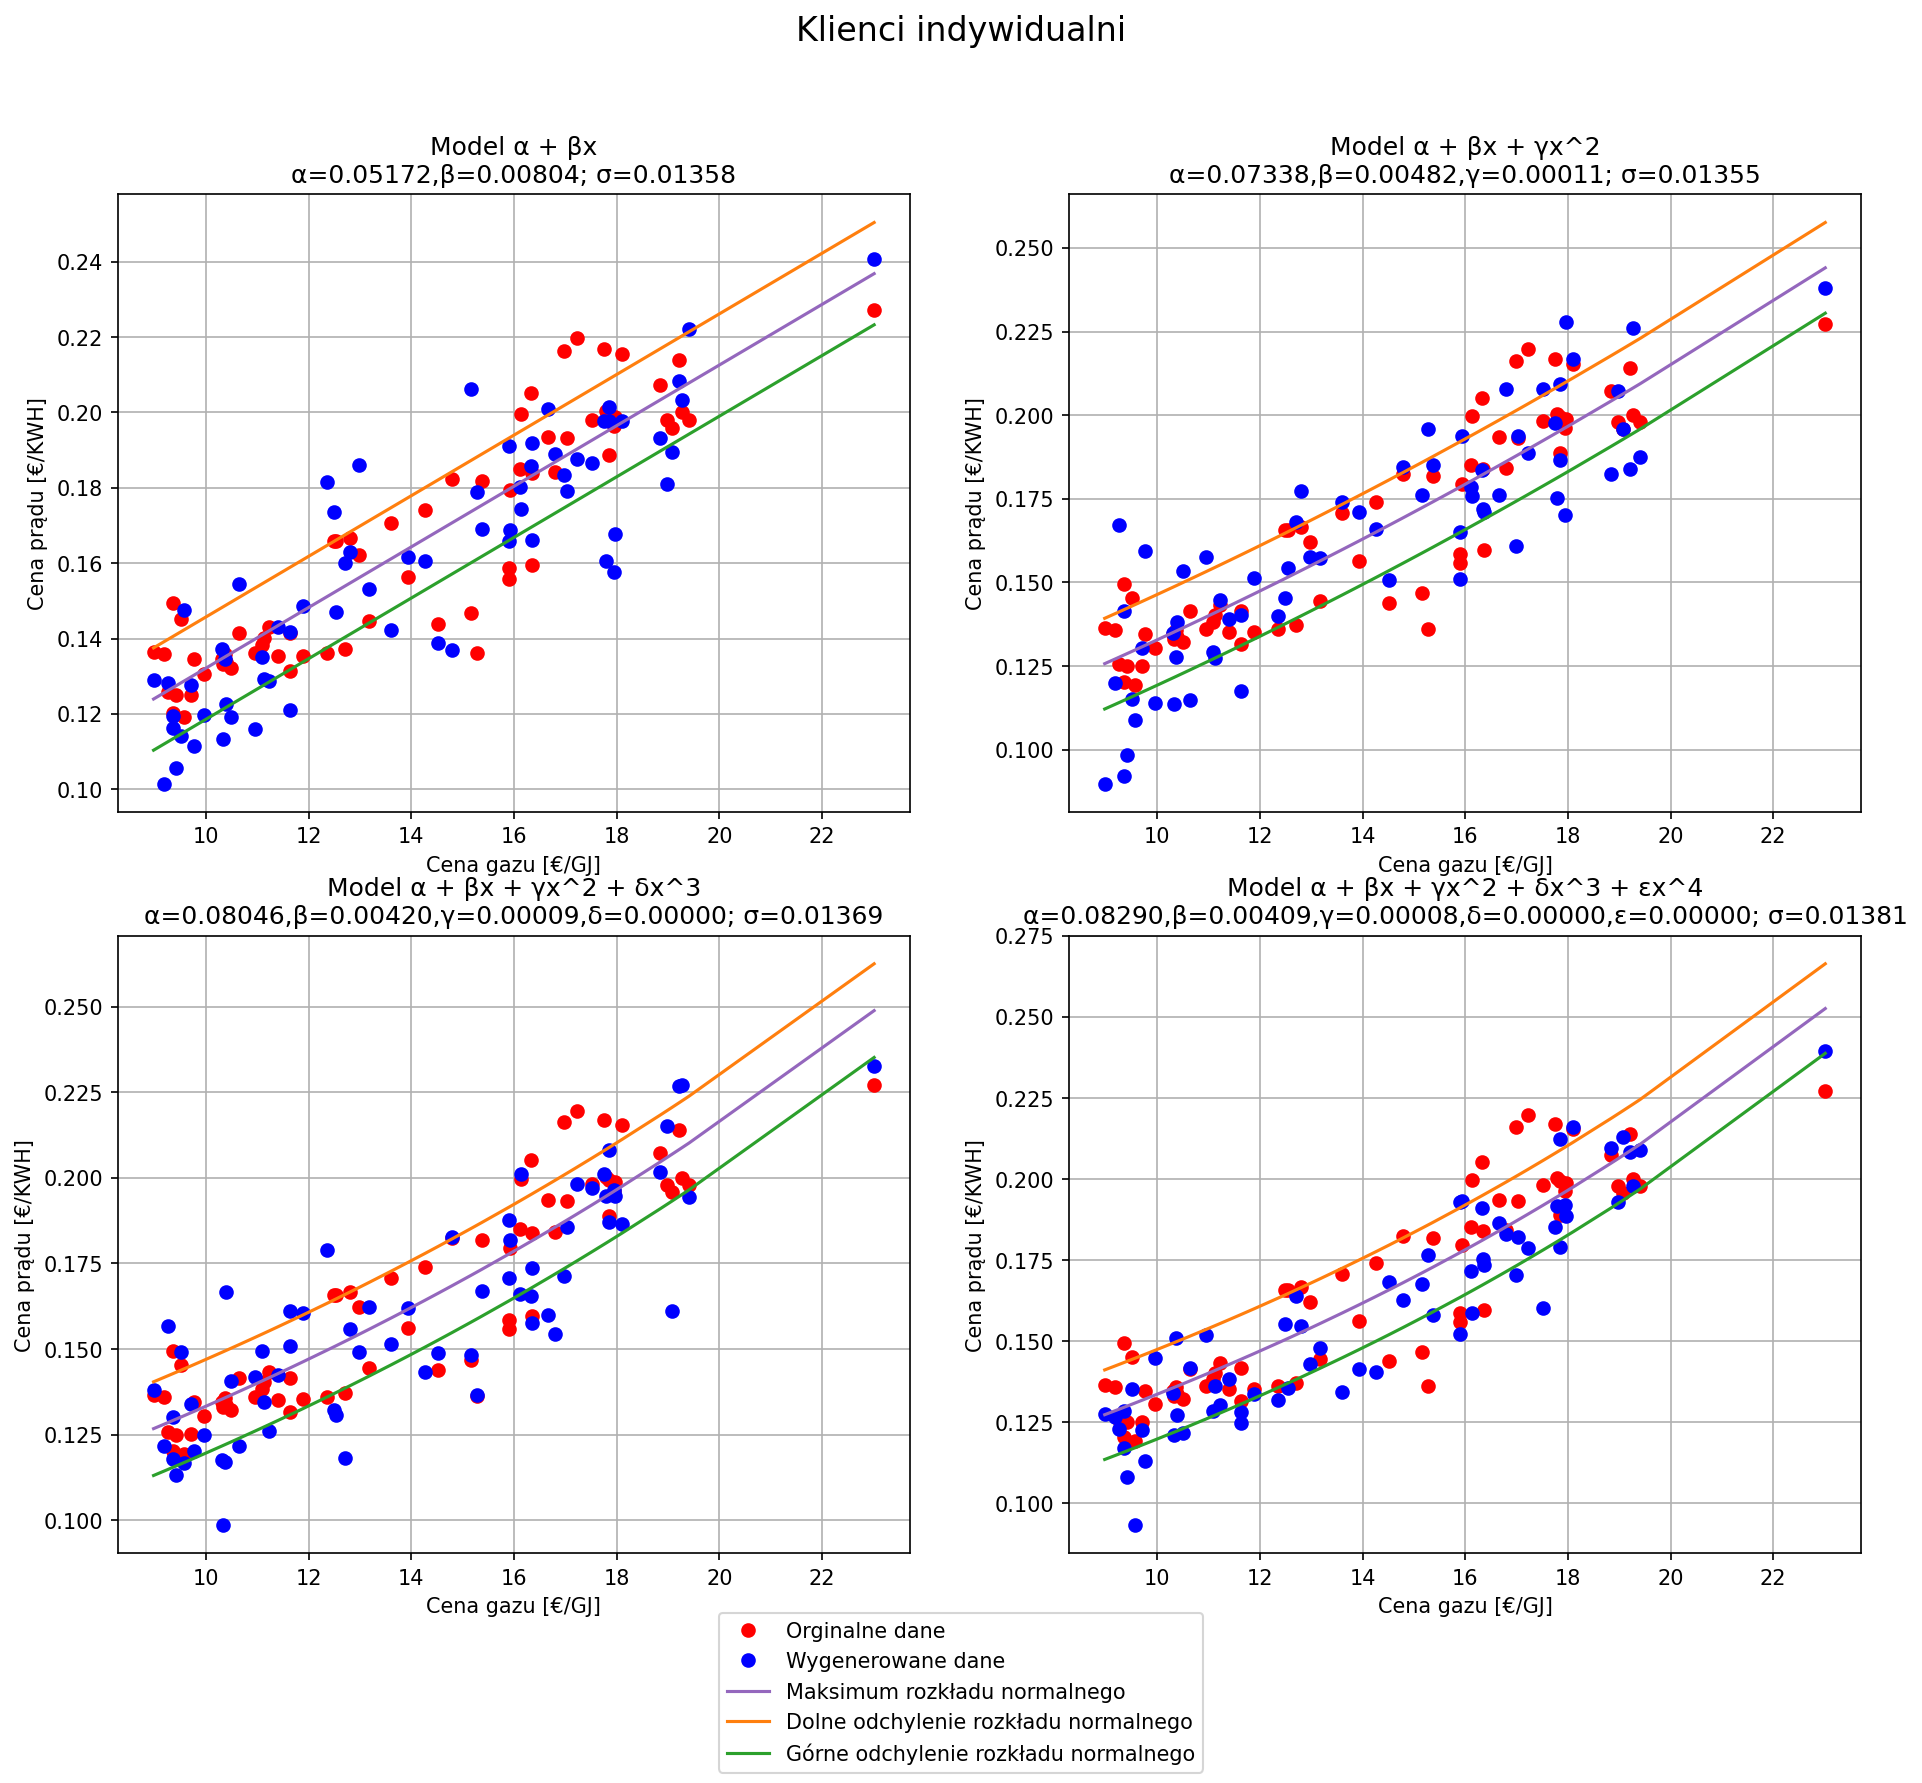

In [32]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree1, 1, axs[0, 0])
PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree2, 2, axs[0, 1])
PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree3, 3, axs[1, 0])
PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree4, 4, axs[1, 1])

f.suptitle('Klienci indywidualni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Dopasowanie klienci indywidualni.png', dpi=300, facecolor='w')
plt.show()

In [33]:
from sklearn.neighbors import KernelDensity
sample = sorted(eh_mean_list)
sample = np.array(sample).reshape(len(sample), 1)
density_model = KernelDensity(bandwidth=2, kernel='gaussian')
density_model.fit(sample)

KernelDensity(bandwidth=2)

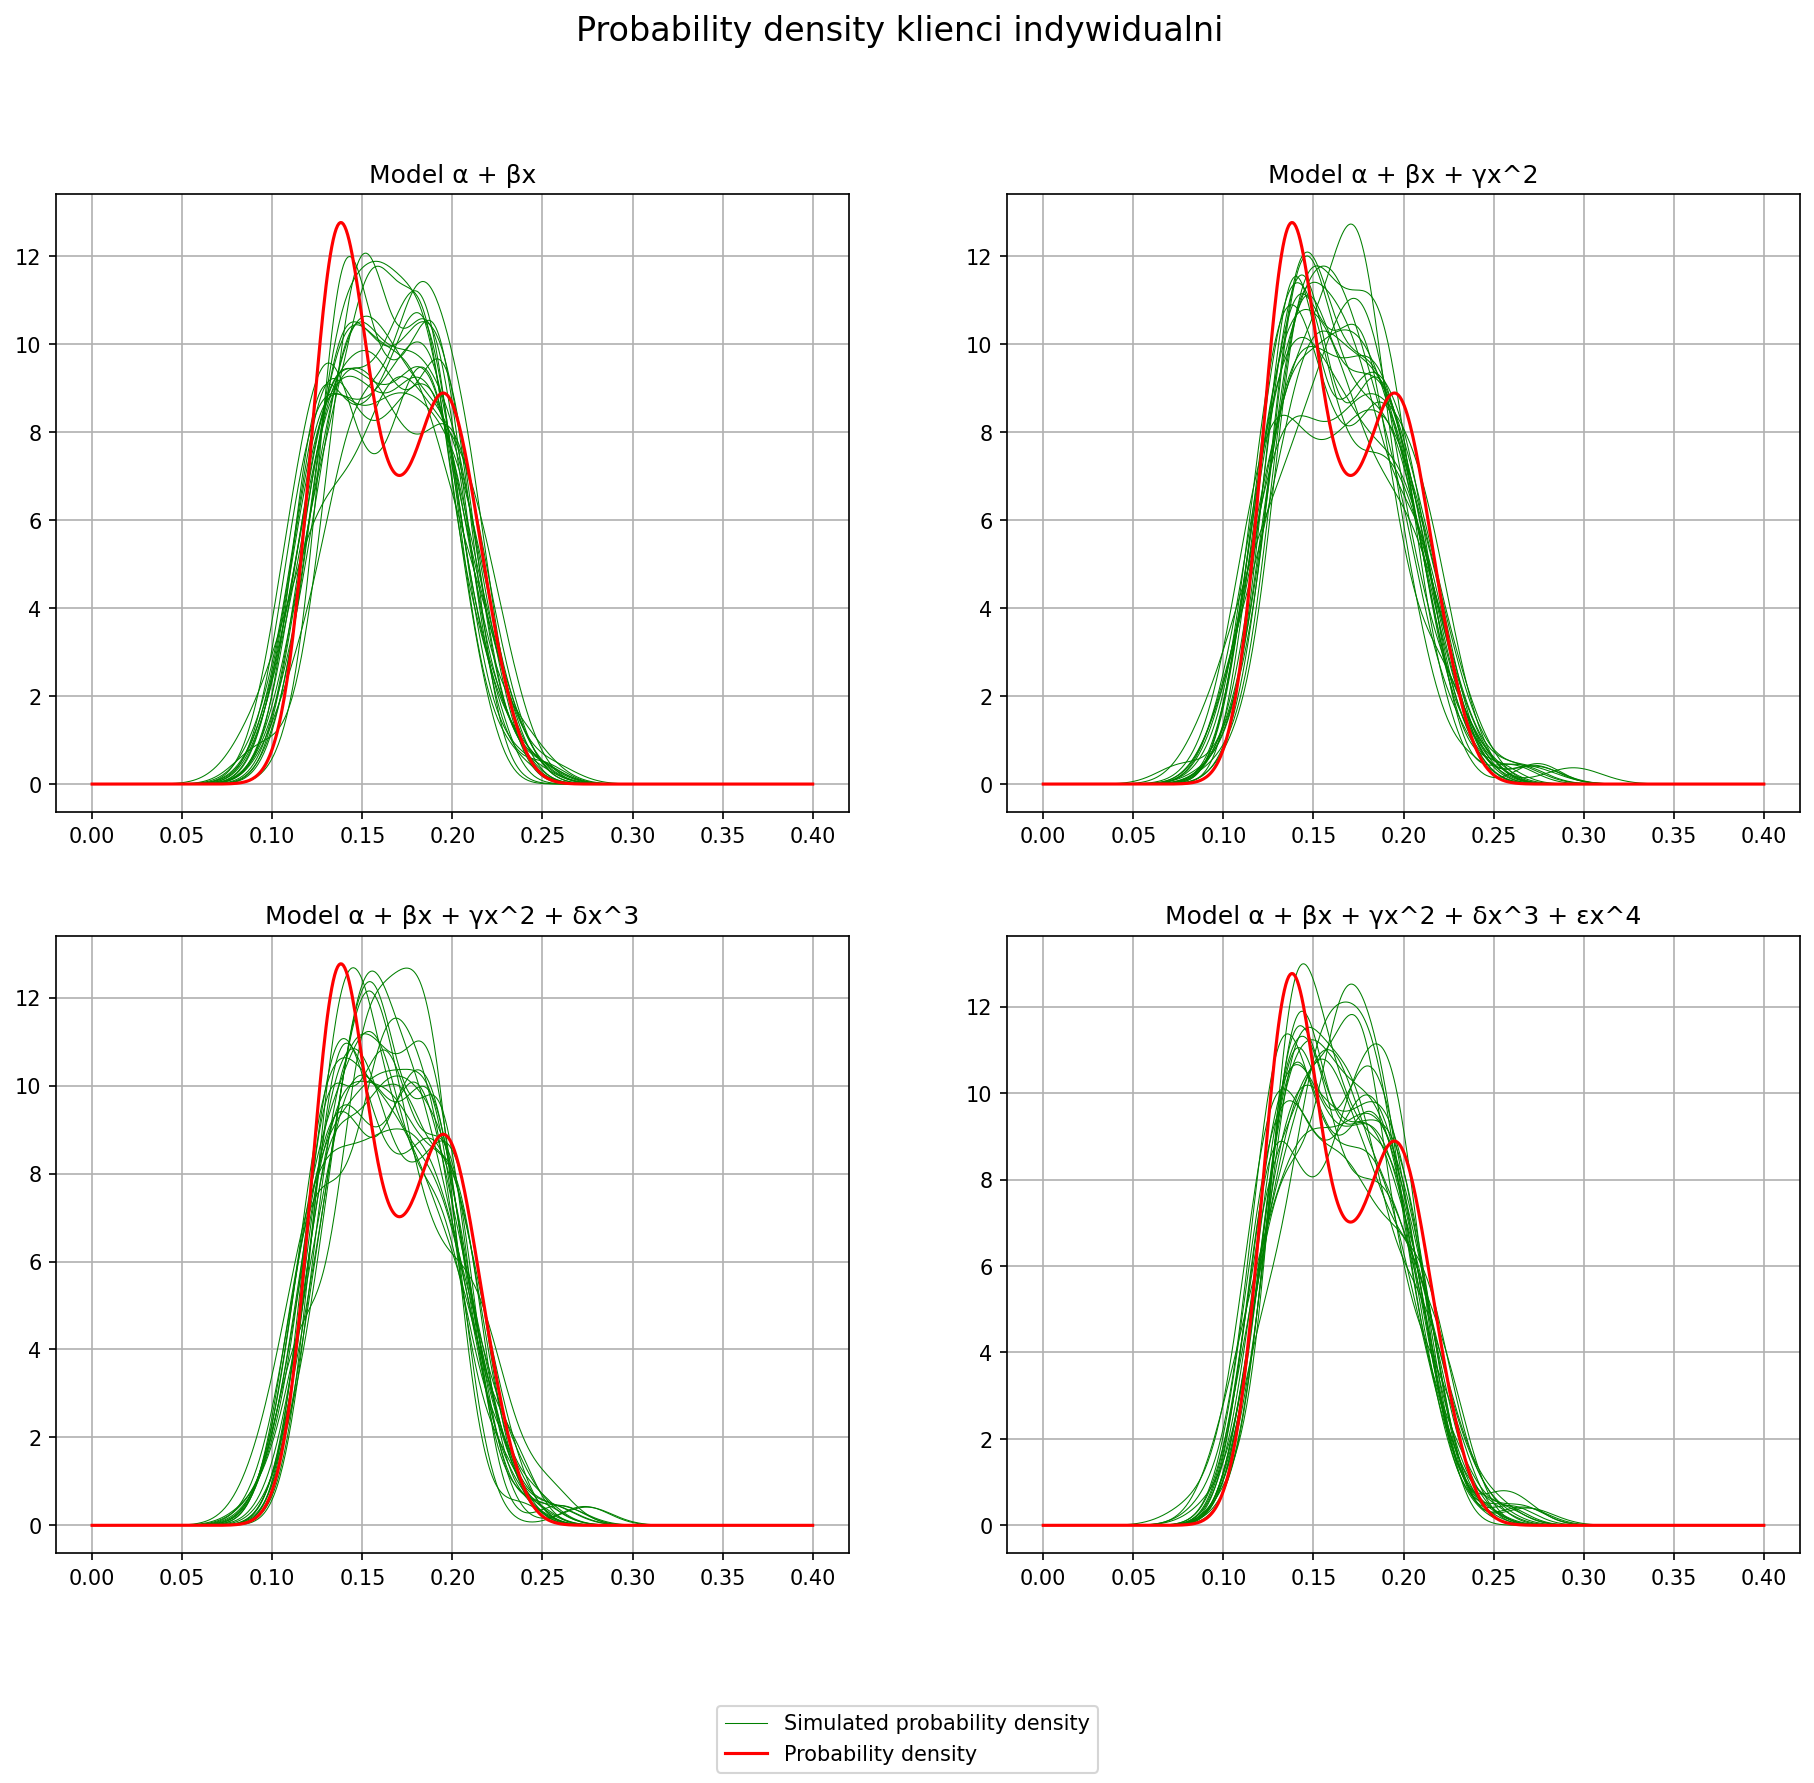

In [34]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

PlotProbabilityDensity(eh_mean_list, h_fit_degree1, 1, axs[0, 0], densityNum=20, linEnd=0.4)
PlotProbabilityDensity(eh_mean_list, h_fit_degree2, 2, axs[0, 1], densityNum=20, linEnd=0.4)
PlotProbabilityDensity(eh_mean_list, h_fit_degree3, 3, axs[1, 0], densityNum=20, linEnd=0.4)
PlotProbabilityDensity(eh_mean_list, h_fit_degree4, 4, axs[1, 1], densityNum=20, linEnd=0.4)

f.suptitle('Probability density klienci indywidualni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Probability density klienci indywidualni.png', dpi=300, facecolor='w')
plt.show()

Dopasowanie wielomianem rzędu = 1, alpha = 0.070612373375, beta = 0.005256523282500001, gamma = None, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 2, alpha = 0.08672243295, beta = 0.00107695451356975, gamma = 0.00023949474699999998, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 3, alpha = 0.08800698489999999, beta = 0.00129482758269525, gamma = 0.00012833337103045, delta = 6.907491102625001e-06, epsilon = None
Dopasowanie wielomianem rzędu = 4, alpha = 0.08839605415, beta = 0.0013803398612025, gamma = 0.00011029207778025001, delta = 5.02116130187425e-06, epsilon = 2.0561583393275002e-07


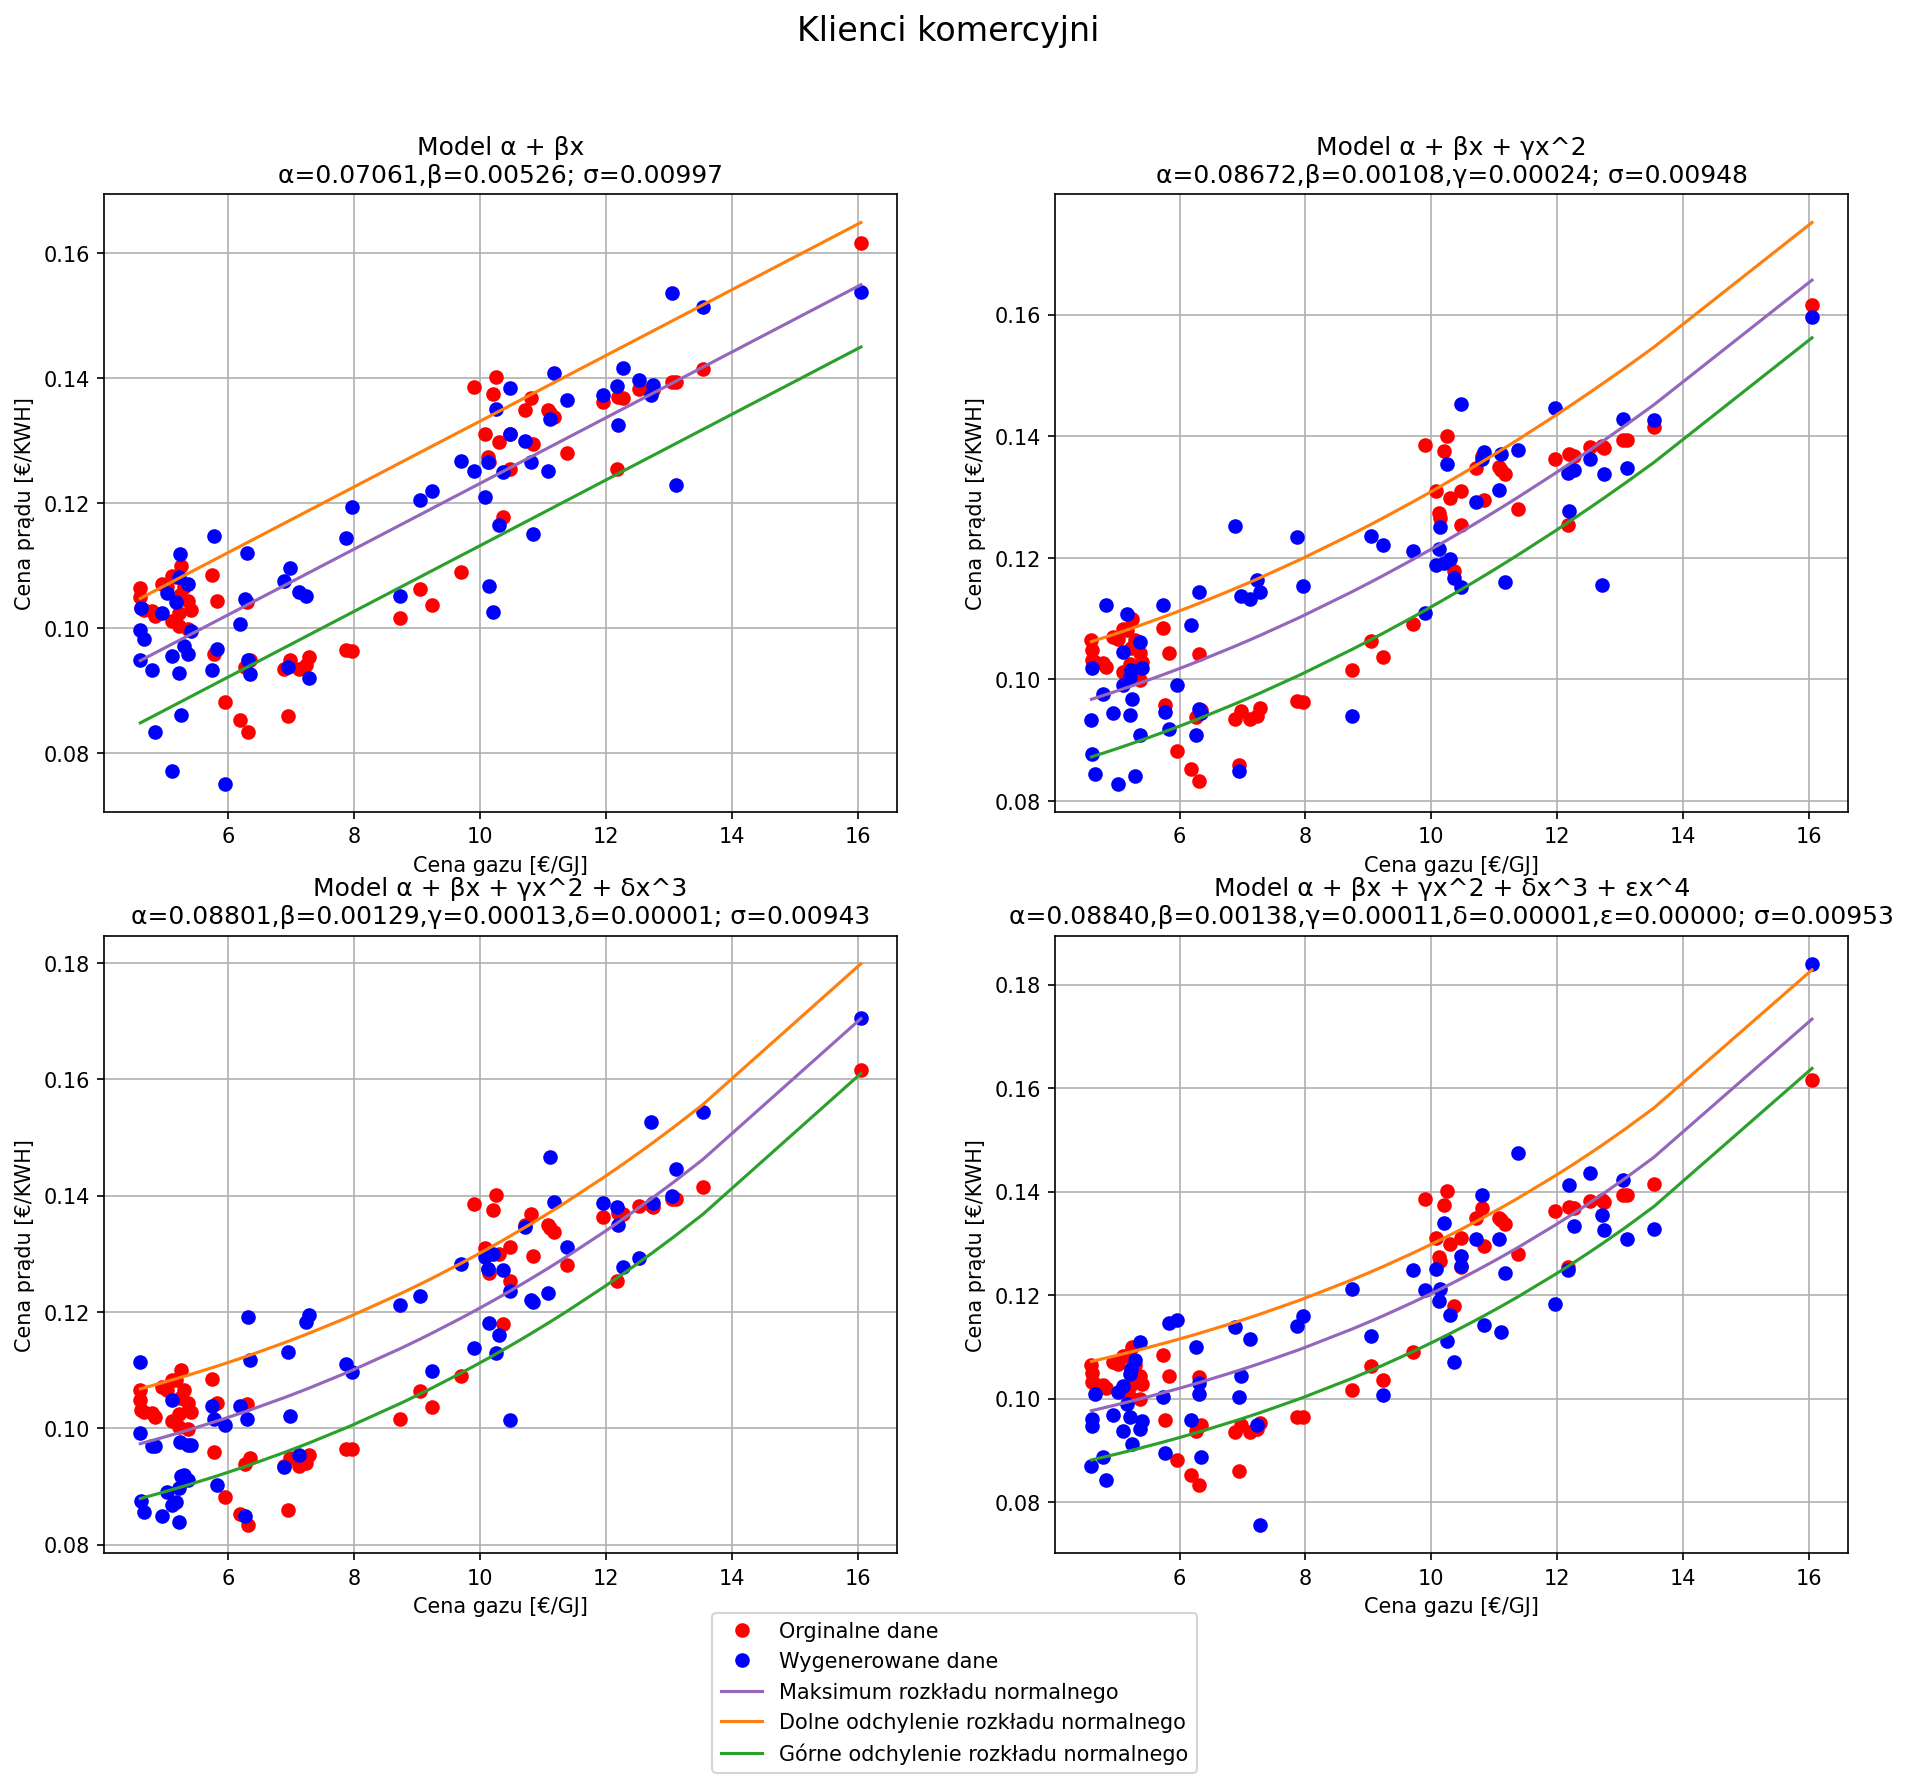

In [35]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree1, 1, axs[0, 0])
PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree2, 2, axs[0, 1])
PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree3, 3, axs[1, 0])
PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree4, 4, axs[1, 1])

f.suptitle('Klienci komercyjni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Dopasowanie klienci komercyjni.png', dpi=300, facecolor='w')
plt.show()

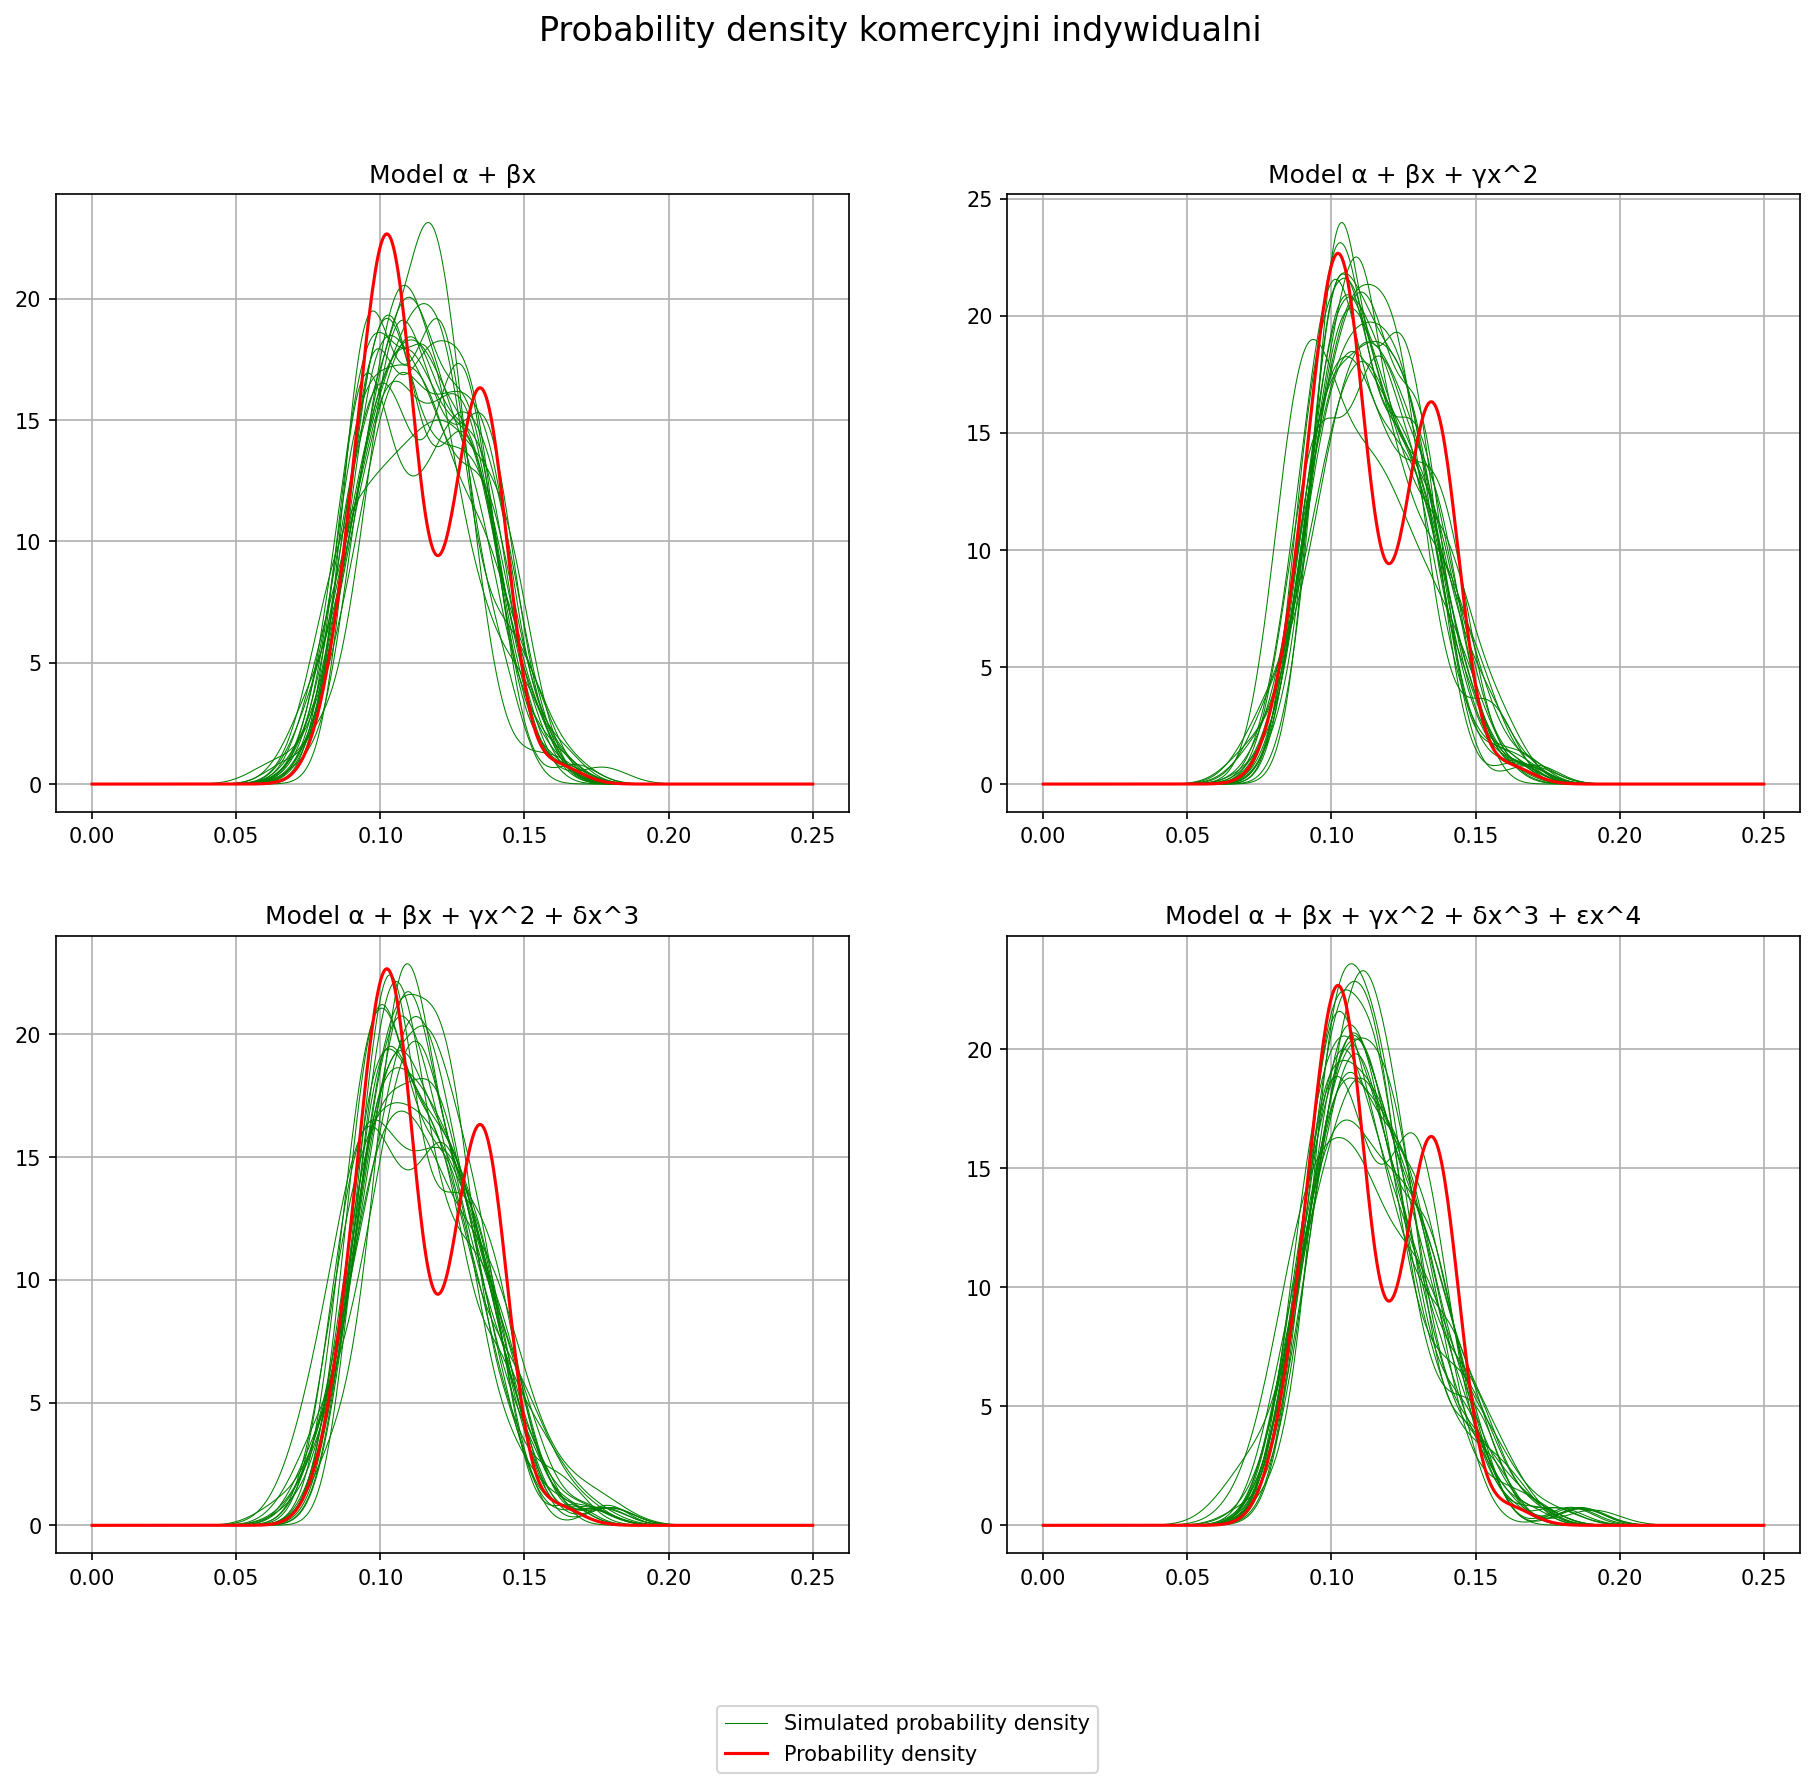

In [36]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

PlotProbabilityDensity(ei_mean_list, i_fit_degree1, 1, axs[0, 0], densityNum=20, linEnd=0.25)
PlotProbabilityDensity(ei_mean_list, i_fit_degree2, 2, axs[0, 1], densityNum=20, linEnd=0.25)
PlotProbabilityDensity(ei_mean_list, i_fit_degree3, 3, axs[1, 0], densityNum=20, linEnd=0.25)
PlotProbabilityDensity(ei_mean_list, i_fit_degree4, 4, axs[1, 1], densityNum=20, linEnd=0.25)

f.suptitle('Probability density komercyjni indywidualni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Probability density komercyjni indywidualni.png', dpi=300, facecolor='w')
plt.show()